In [1]:
# Sam Sung Min Chang
# G01246788
import os 
os.getcwd()

'/Users/sungminchang'

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily
import fsspec
import mapclassify
import folium

In [3]:
# Data and clean up 

# Importing and assigning data 
df = pd.read_csv("https://github.com/babdelfa/project/blob/main/covid19_project.csv?raw=true")

# Melting process
melted = ["FIPS","county", "state", "lat","long_"]
data_melt = pd.melt(df, id_vars=melted, 
                          var_name='dates', 
                          value_name='cases')
# Changing data type of dates 
data_melt['dates'] = pd.to_datetime(data_melt.dates)

# Removing unnecessary records
data_melt[data_melt.lat == 0]['county'].values
data_melt = data_melt[data_melt.county != "Unassigned"].copy()
data_melt = data_melt[data_melt.county.str.contains("Out") == False].copy()
data_melt = data_melt[data_melt.county.str.contains("Correction") == False].copy()

In [4]:
# Part 1
#1 What is the total number of reported COVID-19 cases in the USA?
Updated = data_melt[data_melt.dates == data_melt.dates.max()]
CS_USA = Updated.cases
print("Total # of COVID19 Cases Reported In USA:", CS_USA.sum())

Total # of COVID19 Cases Reported In USA: 47000746


In [6]:
#2 What is the total number of reported COVID-19 cases for Virginia?
state_cases = Updated[(Updated.state == 'Virginia')]
VCS = state_cases.cases
print("Total # of COVID19 Cases Reported In Virginia:", VCS.sum())

Total # of COVID19 Cases Reported In Virginia: 947271


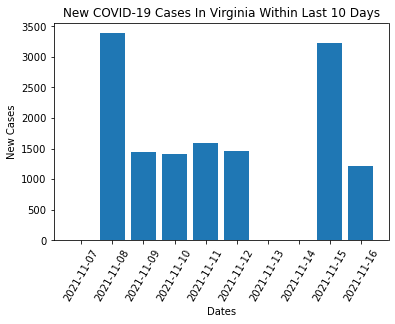

In [8]:
#3 Provide a bar chart displaying the new reported COVID-19cases in Virginia over the last 10 days.
VA_cases = data_melt[(data_melt.state == 'Virginia')]
last_VAC = VA_cases.groupby(['state','dates'])['cases'].sum()
last_VAC = last_VAC.to_frame()
last_VAC.reset_index(inplace = True)
last_VAC = last_VAC[(last_VAC.dates >= '2021-11-06')]
last_VAC['new_cases'] = last_VAC['cases'].diff()

plt.bar(last_VAC.dates,last_VAC.new_cases)
plt.title("New COVID-19 Cases In Virginia Within Last 10 Days")
plt.xlabel("Dates")
plt.ylabel("New Cases")
plt.xticks(rotation=60)
plt.show()

In [10]:
#4 Find the three Virginia counties with the highest reported COVID-19 cases in descending order.
CCS = VA_cases.groupby(['FIPS','county','state','lat','long_'])['cases'].max()
Counties = CCS.to_frame()
Counties.reset_index(inplace = True)
VACounties = Counties.sort_values(by='cases', ascending = False)
VACC = VACounties.head(3)
VACC

,FIPS,county,state,lat,long_,cases
28,51059.0,Fairfax,Virginia,38.836776,-77.275658,93142
72,51153.0,Prince William,Virginia,38.709162,-77.487137,56165
129,51810.0,Virginia Beach,Virginia,36.732857,-76.045669,50628


In [11]:
#5 Find when each of the three Virginia counties (from problem 4) reported their highest number of new COVID-19 cases in a day.
NCS = VA_cases.groupby(['county','dates'])['cases'].sum()
NCS = NCS.to_frame()
NCS.reset_index(inplace = True)
NCS = NCS[NCS['county'].isin(['Fairfax', 'Prince William', 'Virginia Beach'])].copy()
NCS['new_cases'] = NCS['cases'].diff()
CS = NCS.groupby(['county'])['new_cases'].transform(max) == NCS['new_cases']
NCS[CS]

,county,dates,cases,new_cases
24966,Fairfax,2021-01-17,53976,1485.0
66861,Prince William,2021-01-17,31379,1356.0
82395,Virginia Beach,2021-09-13,44829,544.0


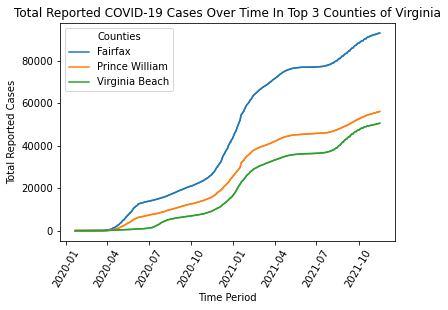

In [13]:
#6 Provide a figure with one subplot that shows three plotted lines - one for each county from problem 4. Each line represents the county’s total reported COVID-19 cases over time.
fig, ax = plt.subplots()
subset_fairfax = NCS[NCS.county == 'Fairfax'].groupby('dates')['cases'].sum().to_frame()
subset_prince = NCS[NCS.county == 'Prince William'].groupby('dates')['cases'].sum().to_frame()
subset_beach = NCS[NCS.county == 'Virginia Beach'].groupby('dates')['cases'].sum().to_frame()

sns.lineplot(x=subset_fairfax.index, y = 'cases', data = subset_fairfax)
sns.lineplot(x= 'dates', y = 'cases', data=subset_prince)
sns.lineplot(x= 'dates', y = 'cases', data=subset_beach)
subset_fairfax['Counties'] = 'Fairfax'
subset_prince['Counties'] = 'Prince William'
subset_beach['Counties'] = 'Virginia Beach'
subs = pd.concat([subset_fairfax,subset_prince,subset_beach])
sns.lineplot(ax=ax, x= 'dates', y= 'cases', data = subs, hue = 'Counties')

ax.set_title("Total Reported COVID-19 Cases Over Time In Top 3 Counties of Virginia")
ax.set_xlabel("Time Period")
ax.set_ylabel("Total Reported Cases")
plt.xticks(rotation=60)
plt.show()

In [14]:
#7 Find the total and average number of new COVID-19 cases reported in October 2021 for Fairfax, Virginia.
OF = NCS[NCS.county.isin(["Fairfax"])]
OF = OF[(OF.dates >= '2021-10-01')&(OF.dates<='2021-10-31')]
OF['new_covidcases'] = OF['cases'].diff()
print('Total New COVID19 Cases In October 2021 for Fairfax, Virginia:', OF.new_covidcases.sum())
print('Total Average of New COVID19 Cases In October 2021 for Fairfax, Virginia:', OF.new_covidcases.mean())

Total New COVID19 Cases In October 2021 for Fairfax, Virginia: 3499.0
Total Average of New COVID19 Cases In October 2021 for Fairfax, Virginia: 116.63333333333334


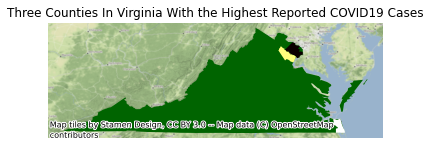

In [16]:
# Part 2 
# Github link for state_geometry
state_path = "//Users/sungminchang/Downloads/state_geometry"
state_geom = gpd.read_file(state_path)
VA_geom = state_geom[(state_geom.STATE_NAME == 'Virginia')]

# Github link for county_geomtery
county_path = "//Users/sungminchang/Downloads/counties_geometry"
county_geom = gpd.read_file(county_path)

# Changing the epsg to 4326 for state and county data
state_geom.crs
county_geom.crs
state_geom = state_geom.to_crs(epsg=4326)
county_geom = county_geom.to_crs(epsg=4326)

# Conversion to geodataframe from question #4 
TC_gdf = gpd.GeoDataFrame(VACC, 
                       crs="epsg:4326", 
                       geometry=gpd.points_from_xy(VACC.long_, VACC.lat))

# Spatial Join function
va_join = gpd.sjoin(county_geom, TC_gdf)

# Choropleth map 
fig, ax = plt.subplots()
VA_geom.plot(ax=ax, color='darkgreen')
va_join.plot(ax=ax, column='cases', cmap='hot_r')
plt.axis("off")
contextily.add_basemap(ax, crs=VA_geom.crs.to_string())
plt.title("Three Counties In Virginia With the Highest Reported COVID19 Cases") 
plt.show()

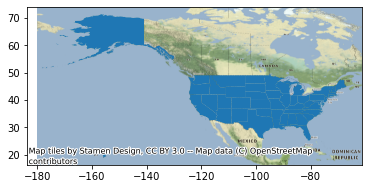

In [17]:
# Contextily basemap
fig, ax = plt.subplots()
state_geom.plot(ax=ax)
contextily.add_basemap(ax, crs=VA_geom.crs.to_string())